# Plan

1. We can narrow down the list of companies by filtering out those with many missing values in the ycharts operating margin dataset.
1. Next, we can use the yfinance python library to check which of the remaining companies have stock prices available in the yfinance dataset.
1. Finally, we can use ycharts to obtain the turnover for the companies that passed both filters.


In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf


In [119]:
import json

with open("./data/ych_filtered_tickers.json") as jsf:
    ych_filtered_tickers = json.load(jsf)
ychopmdf = (
    pd.read_csv(
        "data/ycharts_opm/ycharts_opm_filtered_for_use.csv",
        parse_dates=True,
        index_col=0,
    )
    .sort_index(axis=1)
    .sort_index(axis=0)
)

In [82]:
ych_filtered_tickers[:5]


['A', 'AACAF', 'AACAY', 'AAGRY', 'AAHIF']

In [83]:
ychopmdf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2009-04-01 to 2022-04-01
Columns: 4179 entries, A to SEKEY
dtypes: float64(4179)
memory usage: 457.2 KB


In [84]:
# Input Start and End Date
start = datetime(2009, 1, 1)
end = datetime(2022, 5, 1)

In [90]:
CACHE_PATH = "./data/yf/stocks3m_yf.csv.xz"

In [85]:
# stocks_yf = (
#     yf.download(
#         tickers=ych_filtered_tickers,
#         interval="3mo",
#         start=start,
#         end=end,
#         progress=False,
#         show_errors=False,
#     )
#     .loc[:, ["Adj Close", "Volume"]]
#     .rename({"Adj Close": "adj_close", "Volume": "volume"}, axis=1)
#     .sort_index()
#     .query("index.dt.month == 4")
# )

# tdf.to_csv(path_or_buf=CACHE_PATH, compression="xz", index=True)

In [120]:
stocks_yf = (
    pd.read_csv(
        filepath_or_buffer=CACHE_PATH,
        compression="xz",
        header=[0, 1],
        index_col=[
            0,
        ],
        parse_dates=True,
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
)

In [99]:
stocks_yf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2009-04-01 to 2022-04-01
Columns: 8358 entries, ('adj_close', 'A') to ('volume', 'SEKEY')
dtypes: float64(8358)
memory usage: 914.3 KB


In [100]:
stocks_yf.index

DatetimeIndex(['2009-04-01', '2010-04-01', '2011-04-01', '2012-04-01',
               '2013-04-01', '2014-04-01', '2015-04-01', '2016-04-01',
               '2017-04-01', '2018-04-01', '2019-04-01', '2020-04-01',
               '2021-04-01', '2022-04-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [98]:
stocks_yf.head(2)

adj_close                                                         
                    A     AACAF AACAY AAGRY AAHIF       AAL AALBF      AAON   
Date                                                                          
2009-04-01  13.259851  0.192309   NaN   NaN   NaN  2.290862   NaN  5.151518  \
2010-04-01  18.561193  0.516898   NaN   NaN   NaN  8.117004   NaN  6.138316   

                                 ... volume                                
                  AAP      AAPL  ...  SECYF          SEE SEFJF     SEGXF   
Date                             ...                                       
2009-04-01  39.317070  4.374143  ...    NaN  105106400.0   NaN  267400.0  \
2010-04-01  47.825378  7.724693  ...    NaN   87188600.0   NaN       0.0   

                                                            
           SEHLF         SEIC SEIGF SEIGY SEKEF      SEKEY  
Date                                                        
2009-04-01   NaN  113514400.0   NaN   NaN   NaN  2699200.0  
2010-04-01   NaN   80496800.0   NaN   NaN   NaN  2621000.0  

[2 rows x 8358 columns]

In [121]:
prices, volume = stocks_yf.loc[:, "adj_close"], stocks_yf.loc[:, "volume"]

Check, whether YF prices and volumes have the same NaNs:

In [122]:
# check if there is any cell where one dataframe has a NaN
# value while the other dataframe has a non-NaN value

mask_na = prices.isna() != volume.isna()
if mask_na.any().any():  # type: ignore
    print(
        "One of the dataframes has a NaN value in some cell where the other dataframe has the nonNaN value in the same cell."
    )
else:
    print("Both dataframes have the same NaN values.")

Both dataframes have the same NaN values.


Check, whether yf dataset have discrepancies with ycharts_opm dataset:

In [124]:
all(ychopmdf.columns == prices.columns)

True

In [134]:
all(ychopmdf.index == prices.index)

True

<Axes: xlabel='Number of misses across two datasets', ylabel='Frequency'>

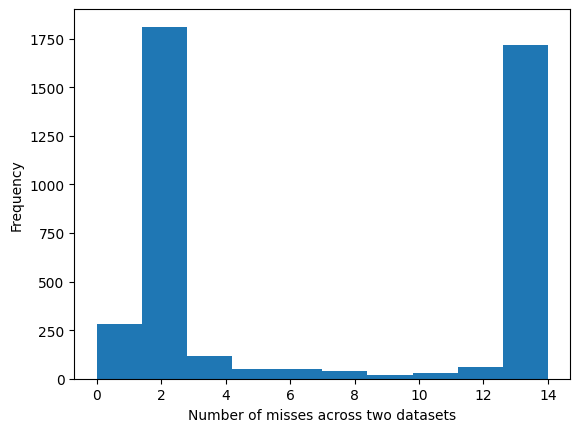

In [140]:
mask_cna = prices.isna() | ychopmdf.isna()
mask_cna.sum().plot(kind="hist", xlabel="Number of misses across two datasets")

In [149]:
prices.isna().sum(1)

Date
2009-04-01    2404
2010-04-01    2199
2011-04-01    2084
2012-04-01    2031
2013-04-01    1969
2014-04-01    1918
2015-04-01    1867
2016-04-01    1852
2017-04-01    1824
2018-04-01    1809
2019-04-01    1790
2020-04-01    1781
2021-04-01    1721
2022-04-01    1693
dtype: int64

In [150]:
prices.where(mask_cna, other=np.nan).isna().sum(1)

Date
2009-04-01    2467
2010-04-01    2508
2011-04-01    4176
2012-04-01    4177
2013-04-01    4177
2014-04-01    4179
2015-04-01    4177
2016-04-01    4174
2017-04-01    4175
2018-04-01    4179
2019-04-01    4178
2020-04-01    4176
2021-04-01    4173
2022-04-01    4165
dtype: int64